# Housing Price Prediction - Model Training & YAML Export

This notebook trains a Random Forest model for housing price prediction and exports the configuration to YAML format for deployment with Streamlit.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import yaml
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load and Explore Data

In [2]:
# Load the training data
print("Loading data...")
train_data = pd.read_csv('train_100k.csv')

# Display basic info
print(f"\nTraining data shape: {train_data.shape}")
print(f"\nColumns: {list(train_data.columns)}")
train_data.head()

Loading data...

Training data shape: (80000, 12)

Columns: ['Id', 'LotArea', 'OverallQual', 'YearBuilt', 'GrLivArea', 'GarageCars', 'FullBath', 'Bedrooms', 'Neighborhood', 'BuildingType', 'RoofStyle', 'SalePrice']


,Id,LotArea,OverallQual,YearBuilt,GrLivArea,GarageCars,FullBath,Bedrooms,Neighborhood,BuildingType,RoofStyle,SalePrice
0,75221,4128,2,1999,3173,2,2,1,West,1Fam,Hip,287816
1,48956,19511,9,1951,3551,0,1,5,North,Duplex,Gable,456786
2,44967,18949,8,1990,1250,3,3,2,Central,Townhouse,Gable,347872
3,13569,15984,1,2018,3045,3,2,4,South,2Fam,Gambrel,332344
4,92728,8247,7,1959,3090,2,3,5,Central,2Fam,Hip,358096


In [3]:
# Data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            80000 non-null  int64 
 1   LotArea       80000 non-null  int64 
 2   OverallQual   80000 non-null  int64 
 3   YearBuilt     80000 non-null  int64 
 4   GrLivArea     80000 non-null  int64 
 5   GarageCars    80000 non-null  int64 
 6   FullBath      80000 non-null  int64 
 7   Bedrooms      80000 non-null  int64 
 8   Neighborhood  80000 non-null  object
 9   BuildingType  80000 non-null  object
 10  RoofStyle     80000 non-null  object
 11  SalePrice     80000 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 7.3+ MB


In [4]:
# Statistical summary
train_data.describe()

,Id,LotArea,OverallQual,YearBuilt,GrLivArea,GarageCars,FullBath,Bedrooms,SalePrice
count,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,50022.926437,10531.964325,4.98440,1985.483475,2251.992300,1.502375,1.999800,2.996863,312078.718137
std,28869.648875,5482.233551,2.58072,20.810286,1009.171385,1.117546,0.817058,1.413100,73049.077229
min,1.000000,1000.000000,1.00000,1950.000000,500.000000,0.000000,1.000000,1.000000,69874.000000
25%,25029.750000,5786.000000,3.00000,1967.000000,1377.000000,1.000000,1.000000,2.000000,260120.500000
50%,50047.000000,10553.000000,5.00000,1986.000000,2252.000000,2.000000,2.000000,3.000000,312176.000000
75%,75038.250000,15269.250000,7.00000,2004.000000,3127.000000,3.000000,3.000000,4.000000,363680.000000
max,99999.000000,19999.000000,9.00000,2021.000000,3999.000000,3.000000,3.000000,5.000000,554828.000000


## 3. Data Preprocessing

In [5]:
# Identify target column
target_cols = [col for col in train_data.columns if 'price' in col.lower() or 'sale' in col.lower()]
if target_cols:
    target_column = target_cols[0]
else:
    target_column = train_data.columns[-1]

print(f"Target column: {target_column}")

# Separate features and target
X = train_data.drop(columns=[target_column])
y = train_data[target_column]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

Target column: SalePrice

Features shape: (80000, 11)
Target shape: (80000,)


In [6]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

print(f"Categorical columns ({len(categorical_cols)}): {list(categorical_cols)}")
print(f"\nNumerical columns ({len(numerical_cols)}): {list(numerical_cols)}")

Categorical columns (3): ['Neighborhood', 'BuildingType', 'RoofStyle']

Numerical columns (8): ['Id', 'LotArea', 'OverallQual', 'YearBuilt', 'GrLivArea', 'GarageCars', 'FullBath', 'Bedrooms']


In [7]:
# Check for missing values
missing_values = X.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found!")

No missing values found!


In [8]:
# One-hot encode categorical variables
print("Encoding categorical variables...")
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Handle missing values
X_encoded = X_encoded.fillna(X_encoded.median())

print(f"\nEncoded features shape: {X_encoded.shape}")
print(f"Total features after encoding: {len(X_encoded.columns)}")

Encoding categorical variables...

Encoded features shape: (80000, 18)
Total features after encoding: 18


## 4. Train-Test Split

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (64000, 18)
Test set: (16000, 18)


## 5. Feature Scaling

In [10]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"Mean of scaled training data: {X_train_scaled.mean():.6f}")
print(f"Std of scaled training data: {X_train_scaled.std():.6f}")

Features scaled using StandardScaler
Mean of scaled training data: -0.000000
Std of scaled training data: 1.000000


## 6. Model Training

In [11]:
# Train Random Forest model
print("Training Random Forest model...\n")

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train_scaled, y_train)
print("\n✓ Model training completed!")

Training Random Forest model...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.6s



✓ Model training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished


## 7. Model Evaluation

In [12]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"Mean Absolute Error (MAE):      ${mae:,.2f}")
print(f"R² Score:                       {r2:.4f}")
print(f"Accuracy:                       {r2*100:.2f}%")
print("="*60)

MODEL PERFORMANCE METRICS
Root Mean Squared Error (RMSE): $21,254.96
Mean Absolute Error (MAE):      $17,008.43
R² Score:                       0.9154
Accuracy:                       91.54%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


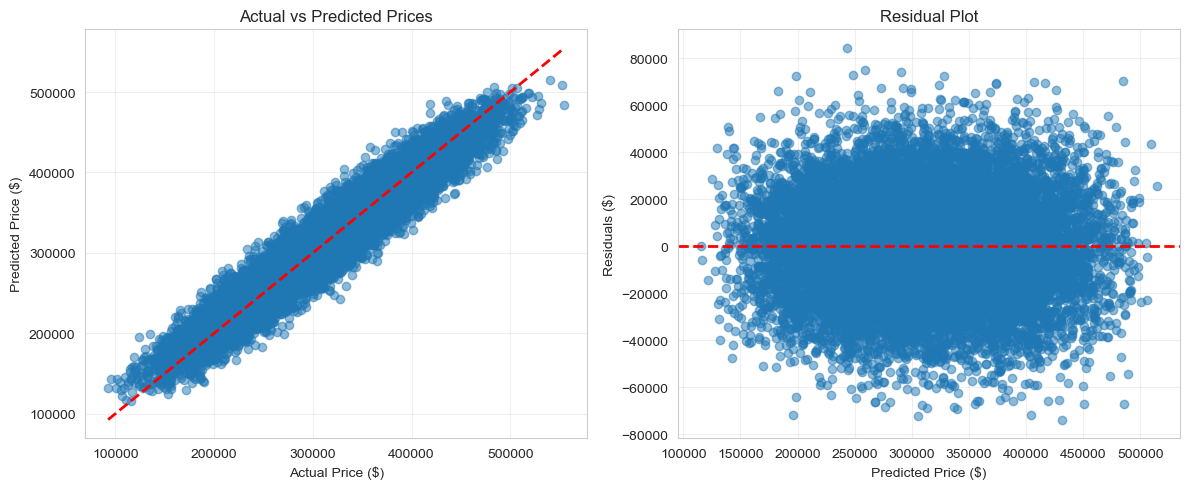

In [13]:
# Visualize predictions vs actual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Prices')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

In [14]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print("="*60)
for idx, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:30s} {row['importance']*100:6.2f}%")
print("="*60)


Top 15 Most Important Features:
GrLivArea                       49.36%
OverallQual                     28.56%
LotArea                         15.56%
GarageCars                       2.34%
YearBuilt                        1.32%
Id                               1.06%
Bedrooms                         0.41%
FullBath                         0.26%
RoofStyle_Gambrel                0.12%
BuildingType_Duplex              0.12%
BuildingType_Townhouse           0.12%
RoofStyle_Hip                    0.12%
BuildingType_2Fam                0.12%
RoofStyle_Gable                  0.11%
Neighborhood_East                0.11%


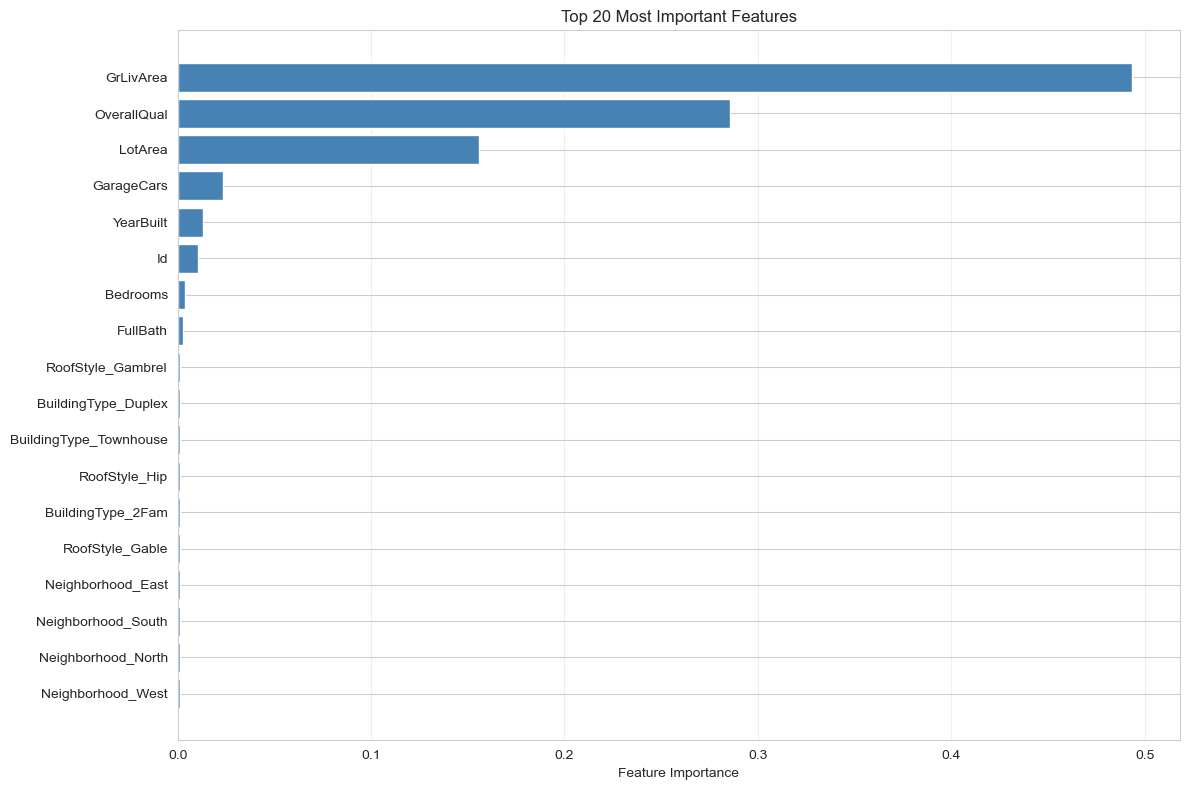

In [15]:
# Visualize top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 9. Save Model and Export to YAML

In [16]:
# Save the model and scaler
print("Saving model artifacts...")
joblib.dump(model, 'housing_price_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Save feature names
with open('feature_names.json', 'w') as f:
    json.dump(list(X_train.columns), f)

print("✓ Model saved to: housing_price_model.pkl")
print("✓ Scaler saved to: scaler.pkl")
print("✓ Feature names saved to: feature_names.json")

Saving model artifacts...
✓ Model saved to: housing_price_model.pkl
✓ Scaler saved to: scaler.pkl
✓ Feature names saved to: feature_names.json


In [17]:
# Create YAML configuration
model_config = {
    'model_info': {
        'name': 'Housing Price Prediction Model',
        'type': 'RandomForestRegressor',
        'version': '1.0',
        'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'description': 'Random Forest model for predicting housing prices'
    },
    'hyperparameters': {
        'n_estimators': 100,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42
    },
    'data_info': {
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'total_features': len(X_train.columns),
        'categorical_features': len(categorical_cols),
        'numerical_features': len(numerical_cols),
        'target_column': target_column
    },
    'performance_metrics': {
        'rmse': float(rmse),
        'mae': float(mae),
        'r2_score': float(r2),
        'accuracy_percentage': float(r2 * 100)
    },
    'feature_importance': {
        row['feature']: float(row['importance']) 
        for _, row in feature_importance.head(20).iterrows()
    },
    'preprocessing': {
        'scaling': 'StandardScaler',
        'categorical_encoding': 'One-Hot Encoding',
        'missing_value_strategy': 'Median Imputation'
    },
    'files': {
        'model_file': 'housing_price_model.pkl',
        'scaler_file': 'scaler.pkl',
        'feature_names_file': 'feature_names.json'
    }
}

# Save YAML configuration
print("\nExporting model configuration to YAML...")
with open('model_config.yaml', 'w') as f:
    yaml.dump(model_config, f, default_flow_style=False, sort_keys=False)

print("✓ Configuration saved to: model_config.yaml")


Exporting model configuration to YAML...
✓ Configuration saved to: model_config.yaml


In [18]:
# Display the YAML configuration
print("\n" + "="*60)
print("YAML CONFIGURATION PREVIEW")
print("="*60)
print(yaml.dump(model_config, default_flow_style=False, sort_keys=False))
print("="*60)


YAML CONFIGURATION PREVIEW
model_info:
  name: Housing Price Prediction Model
  type: RandomForestRegressor
  version: '1.0'
  created_date: '2025-11-30 20:52:22'
  description: Random Forest model for predicting housing prices
hyperparameters:
  n_estimators: 100
  max_depth: 20
  min_samples_split: 5
  min_samples_leaf: 2
  random_state: 42
data_info:
  training_samples: 64000
  test_samples: 16000
  total_features: 18
  categorical_features: 3
  numerical_features: 8
  target_column: SalePrice
performance_metrics:
  rmse: 21254.96165469236
  mae: 17008.42542903296
  r2_score: 0.9154274153537131
  accuracy_percentage: 91.5427415353713
feature_importance:
  GrLivArea: 0.49360000017685374
  OverallQual: 0.2856155860163834
  LotArea: 0.15561823790219736
  GarageCars: 0.023423920115530076
  YearBuilt: 0.013168369144603682
  Id: 0.010639665264509709
  Bedrooms: 0.004058526215749701
  FullBath: 0.002584319264462868
  RoofStyle_Gambrel: 0.0012215413655614865
  BuildingType_Duplex: 0.001185

## 10. Summary

In [19]:
print("\n" + "="*60)
print("✓ MODEL TRAINING AND EXPORT COMPLETED!")
print("="*60)
print(f"\n📊 Model Performance:")
print(f"   - Accuracy: {r2*100:.2f}%")
print(f"   - RMSE: ${rmse:,.2f}")
print(f"   - MAE: ${mae:,.2f}")
print(f"\n📁 Generated Files:")
print(f"   - housing_price_model.pkl (trained model)")
print(f"   - scaler.pkl (feature scaler)")
print(f"   - feature_names.json (feature list)")
print(f"   - model_config.yaml (configuration)")
print(f"\n🚀 Next Steps:")
print(f"   Run the Streamlit app: streamlit run app.py")
print(f"   Open browser at: http://localhost:8501")
print("="*60)


✓ MODEL TRAINING AND EXPORT COMPLETED!

📊 Model Performance:
   - Accuracy: 91.54%
   - RMSE: $21,254.96
   - MAE: $17,008.43

📁 Generated Files:
   - housing_price_model.pkl (trained model)
   - scaler.pkl (feature scaler)
   - feature_names.json (feature list)
   - model_config.yaml (configuration)

🚀 Next Steps:
   Run the Streamlit app: streamlit run app.py
   Open browser at: http://localhost:8501


## 11. Test Predictions (Optional)

In [20]:
# Load test data and make predictions
try:
    test_data = pd.read_csv('test_100k.csv')
    print(f"Loaded test data: {test_data.shape}")
    
    # Preprocess test data
    X_test_encoded = pd.get_dummies(test_data)
    
    # Align columns with training data
    missing_cols = set(X_train.columns) - set(X_test_encoded.columns)
    for col in missing_cols:
        X_test_encoded[col] = 0
    
    X_test_encoded = X_test_encoded[X_train.columns]
    X_test_encoded = X_test_encoded.fillna(X_test_encoded.median())
    
    # Scale and predict
    X_test_scaled = scaler.transform(X_test_encoded)
    test_predictions = model.predict(X_test_scaled)
    
    # Create results dataframe
    results = pd.DataFrame({
        'Id': range(len(test_predictions)),
        'Predicted_Price': test_predictions
    })
    
    print(f"\n✓ Generated {len(test_predictions):,} predictions")
    print(f"\nPrediction Statistics:")
    print(f"   Average: ${test_predictions.mean():,.2f}")
    print(f"   Median:  ${np.median(test_predictions):,.2f}")
    print(f"   Min:     ${test_predictions.min():,.2f}")
    print(f"   Max:     ${test_predictions.max():,.2f}")
    
    # Save predictions
    results.to_csv('housing_price_predictions.csv', index=False)
    print(f"\n✓ Predictions saved to: housing_price_predictions.csv")
    
    # Display first few predictions
    print("\nFirst 10 predictions:")
    display(results.head(10))
    
except FileNotFoundError:
    print("Test file 'test_100k.csv' not found. Skipping test predictions.")

Loaded test data: (20000, 11)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s



✓ Generated 20,000 predictions

Prediction Statistics:
   Average: $311,565.71
   Median:  $312,099.12
   Min:     $103,723.50
   Max:     $511,321.07

✓ Predictions saved to: housing_price_predictions.csv

First 10 predictions:


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


,Id,Predicted_Price
0,0,354727.849990
1,1,362016.871133
2,2,281141.644187
3,3,430502.152329
4,4,274025.293210
5,5,211838.174714
6,6,265220.307722
7,7,216001.105952
8,8,258566.850536
9,9,381136.737587
